In [1]:
%matplotlib notebook
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
from astropy.io import fits
import init_cfg as ic
from astropy.stats import SigmaClip
from photutils import MMMBackground
from photutils import StdBackgroundRMS
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
from photutils.isophote import EllipseGeometry, Ellipse
from matplotlib.patches import Ellipse as ell

In [2]:
def make_segm(image, threshold, fwhm):
    '''
    image - image 2D array (dtype: numpy.array)
    threshold - threshold pixel value (dtype: numpy.float)
    fwhm - FWHM of the kernel for detecting sources (dtype: numpy.float)
    '''
    sigma = fwhm * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=2, y_size=2)
    kernel.normalize()
    segm = detect_sources(image, threshold, npixels=5, filter_kernel=kernel)
    
    fig, ax = plt.subplots()
    ax.imshow(segm.data, origin='lower', cmap='gray_r')
    plt.tight_layout()
    
    return segm.data

In [3]:
def get_segm(imgname, out, thresh_sigma, center_x, center_y,
             clip_sigma=3.0, kernel_fwhm=5.0):
    '''
    imgname - name of the image (dtype: string)
    out - name of the output segmentation image (dtype: string)
    thresh_sigma - threshold sigma (dtype: numpy.float)
    center_x - DS9 X coordinate of the galaxy center (dtype: numpy.float)
    center_y - DS9 Y coordinate of the galaxy center (dtype: numpy.float)
    clip_sigma - sigma value for clipping (default: 3.0)
    kernel_fwhm - FWHM value for detecting sources (default: 5.0)
    '''
    img, hdr = fits.getdata(imgname, header=True, ext=0)
    
    sigma_clip = SigmaClip(sigma=clip_sigma)
    
    bkg = MMMBackground(sigma_clip = sigma_clip)
    bkg_value = bkg.calc_background(img)
    
    bkgrms = StdBackgroundRMS(sigma_clip)
    bkgrms_value = bkgrms.calc_background_rms(img)
    
    print(bkg_value, bkgrms_value)
    
    segm = make_segm(img, bkg_value + thresh_sigma*bkgrms_value, kernel_fwhm)
    segm0 = segm[int(round(center_y)-1), int(round(center_x)-1)]
    
    segm[segm != segm0] = 0
    segm[segm == segm0] = 1
    
    img_seg = img*segm
    img_seg[segm == 0] = np.maximum(0, bkg_value)
    
    fits.writeto(out, img_seg, overwrite=True)
    
    return [img_seg, bkg_value, bkgrms_value]

(0.0010842008023627964, 0.009065848761435048)


<IPython.core.display.Javascript object>


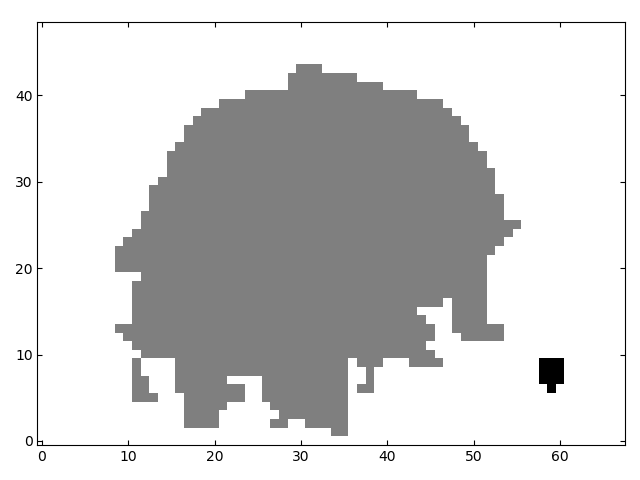

In [4]:
# hstImg = "/data/jlee/DATA/HLA/McPartland+16/MACS1752/JFG2/Phot/814_ori.fits"
gemImg = ic.cpath+"diagram/wavcut_Halpha+NII.fits"

# hst_img = fits.getdata(hstImg, header=False, ext=0)
gem_img = fits.getdata(gemImg, header=False, ext=0)

# hst_seg, hst_bkg, hst_bkgrms = get_segm(hstImg, "hst_segm.fits", 1.0, center_x=205.0, center_y=230.0)
gem_seg, gem_bkg, gem_bkgrms = get_segm(gemImg, "gem_segm.fits", 1.0, center_x=33.0, center_y=30.0)

The follow step requires some manual processes with displaying images using DS9.

The two regions files are needed.

* A masking region file to remove disturbed regions
* An initial ellipse region file to give initial conditions for ellipse fitting

Plus, note that ``reg_saoimage.py`` should be in your Python path. ([Reference link](https://github.com/joungh93/Lib_jlee/blob/master/reg_saoimage.py))

In [5]:
from reg_saoimage import read_region

In [6]:
def do_mask(imgdata, mask_region, mask_type, show=True,
            origin='lower', cmap='gray_r', vmin=-0.01, vmax=0.05):
    '''
    imgdata - image data array (dtype: numpy.array)
    mask_region - the masking region file (dtype: string)
    mask_type - the mask type of the region file (dtype: string)
    show - if True, plot the masked imgdata (default: True)
    origin - the position of the origin if show is True
    cmap - matplotlib color map of the figure if show is True
    vmin - scale minimum limit if show is True
    vmax - scale maximum limit if show is True
    '''
    imgdata_msk = copy.deepcopy(imgdata)
    x_cen, y_cen, x_size, y_size, _ = read_region(mask_region, regtype=mask_type)
    for x0, y0, xs, ys in zip(x_cen, y_cen, x_size, y_size):
        imgdata_msk[int(round(y0-1-ys/2)):int(round(y0-1+ys/2)),
                    int(round(x0-1-xs/2)):int(round(x0-1+xs/2))] = 0.
#         imgdata_msk = np.ma.masked_equal(imgdata_msk, -99*np.ones(shape=imgdata_msk.shape))
    
    if show:
        fig, ax = plt.subplots()
        ax.imshow(imgdata_msk, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.tight_layout()
    
    return imgdata_msk

<IPython.core.display.Javascript object>


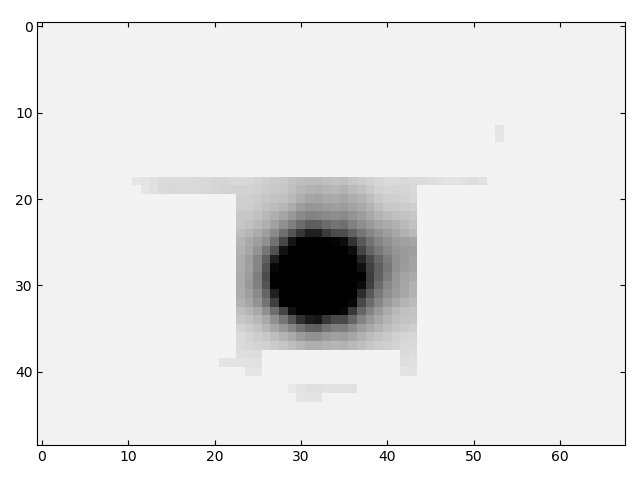

In [11]:
# hst_seg_msk = do_mask(hst_seg, 'hst_msk.reg', 'box')
gem_seg_msk = do_mask(gem_seg, 'gem_msk.reg', 'box',
                      origin='upper', vmin=-0.01, vmax=0.2)
# fits.writeto("hst_seg_msk.fits", hst_seg_msk, overwrite=True)
fits.writeto("gem_seg_msk.fits", gem_seg_msk, overwrite=True)

In [12]:
current_dir = os.getcwd()
os.chdir(ic.dir_root)

from pyraf import iraf

iraf.stsdas()
iraf.stsdas.analysis()
iraf.stsdas.analysis.isophote()

os.chdir(current_dir)
iraf.chdir(current_dir)



      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
      |                   STSDAS Version 3.18.3                    |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      |                                                            |
      +------------------------------------------------------------+
stsdas/:
 analysis/      examples        hst_calib/      sobsolete/
 contrib/       fitsio/         playpen/        toolbox/
 describe       graphics/       problems
isophote/:
 bmodel         geompar@        isomap          magpar@
 contr

In [13]:
def fit_ellipse(input_image, initial_guess_region, step=0.05, maxsma=100.,
                plot_isophot=True, imgdata=None, n_isophot=4,
                origin='lower', cmap='gray_r', vmin=-0.01, vmax=0.05,
                plot_profile=True, boundary_value=None):
    '''
    input_image - the input image of the masked data array (dtype: string)
    initial_guess_region - the initial ellipse region from DS9 (dtype: string)
    step - step for ellipse fitting (dtype: numpy.float)
    maxsma - maximum semi-major axis for ellipse fitting (dtype: numpy.float)
    plot_isophot - if True, plot the isophotal lines over the image data (default: True)
    imgdata - the original image data array (dtype: np.array)
    n_isophot - the number of isophot lines to plot (dtype: numpy.int)
    origin, cmap, vmin, vmax - matplotlib plot parameters
    plot_profile - if True, plot the intensity profile (default: True)
    boundary_value - the galaxy & tail boundary value (dtype: numpy.float)
    '''
    x0, y0, a, b, pa = read_region(initial_guess_region, regtype='ellipse')
    x0, y0 = x0[0], y0[0]
    sma, eps = a[0], b[0]/a[0]
    if ((pa[0]-90.) % 180 > 90.):
        pa = (pa[0]-90.) % 180 - 180.
    elif ((pa[0]-90.) % 180 == 0):
        pa = 1./3600
    else:
        pa = (pa[0]-90.) % 180
  
    iname = input_image.split('.fits')[0]

    os.system('rm -rfv '+iname+'.tab colnames.lis '+iname+'.dat')
    
    iraf.ellipse(input=iname+'.fits', output=iname+'.tab', interac='no',
                 x0=x0, y0=y0, ellip0=eps, pa0=pa, sma0=sma, minsma=0.0, maxsma=maxsma, step=step,
                 linear='no', recenter='no', mag0=25.0, refer=1.0E-5, zerolev=0.0, maxit=100,
                 hcenter='no', hellip='no', hpa='no')

    iraf.tlcol(iname+'.tab', nlist=1, Stdout='colnames.lis')
    iraf.tdump(table=iname+'.tab', columns="@colnames.lis", datafile=iname+'.dat')
    
    f = open("colnames.lis", "r")
    cc = f.readlines()
    f.close()

    colnames = []
    for line in cc:
        if not (line[0] == '#'):
            colnames.append(line.split(' ')[0])
    print(colnames)
    
    iso_tbl = np.genfromtxt(iname+".dat", encoding="ascii", names=colnames)

    if plot_isophot:
        fig, ax = plt.subplots()
        ax.imshow(imgdata, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)

        smas = np.linspace(0.2*maxsma, 0.8*maxsma, 4)
        for sma in smas:
            idx = np.abs(iso_tbl['SMA'] - sma).argmin()
            e = ell((iso_tbl['X0'][idx], iso_tbl['Y0'][idx]),
                    width=2*iso_tbl['SMA'][idx],
                    height=2*iso_tbl['SMA'][idx]*(1-iso_tbl['ELLIP'][idx]),
                    angle=iso_tbl['PA'][idx]+90.,
                    fill=False, color='red', linestyle='-', linewidth=1.25)
            ax.add_patch(e)
    
    if plot_profile:
        fig, ax = plt.subplots()
        ax.set_xlabel(r"${\rm SMA}^{1/4}$")
        ax.set_ylabel("Log (Intensity)")
        ax.set_xlim([0.0, maxsma**0.25])
        ymin = np.log10(iso_tbl['INTENS'][iso_tbl['INTENS'] > 0.].min()*0.5)
        ymax = np.log10(iso_tbl['INTENS'][iso_tbl['INTENS'] > 0.].max()/0.5)
        ax.set_ylim([ymin, ymax])
        ax.plot(iso_tbl['SMA']**0.25, np.log10(iso_tbl['INTENS']), 'o', ms=3.0)
        ax.axhline(np.log10(boundary_value), 0.0, maxsma**0.25,
                   linestyle='-', linewidth=1.5, color='gray', alpha=0.9)
        plt.tight_layout()
    
    return iso_tbl

In [14]:
# hst_boundary = np.maximum(hst_bkg, 0) + 1.0*hst_bkgrms
gem_boundary = np.maximum(gem_bkg, 0) + 1.0*gem_bkgrms

Running object locator... Done.
#
# Semi-    Isophote      Ellipticity     Position   Grad.  Data Flag Iter. Stop
# major      mean                         Angle      rel.                  code
# axis     intensity                                error
#(pixel)                                 (degree)
#
   5.45     0.17(  0.01) 0.081(0.010)  87.09( 3.79) 0.052   33   0    20    0
   5.72     0.16(  0.01) 0.082(0.010)  86.07( 3.86) 0.052   35   0    10    0
   6.01     0.14(  0.01) 0.084(0.009)  85.53( 3.32) 0.050   36   0    10    0
   6.31     0.13(  0.01) 0.089(0.009)  84.16( 3.18) 0.049   38   0    10    0
   6.62     0.12(  0.00) 0.099(0.009)  84.16( 2.63) 0.048   40   0    10    0
   6.95     0.11(  0.00) 0.106(0.008)  83.14( 2.28) 0.046   42   0    10    0
   7.30     0.10(  0.00) 0.111(0.008)  82.42( 2.17) 0.047   44   0    10    0
   7.66     0.09(  0.00) 0.117(0.008)  81.48( 2.10) 0.051   46   0    10    0
   8.05     0.08(  0.00) 0.124(0.008)  80.89( 2.00) 0.053   48   0    10

<IPython.core.display.Javascript object>


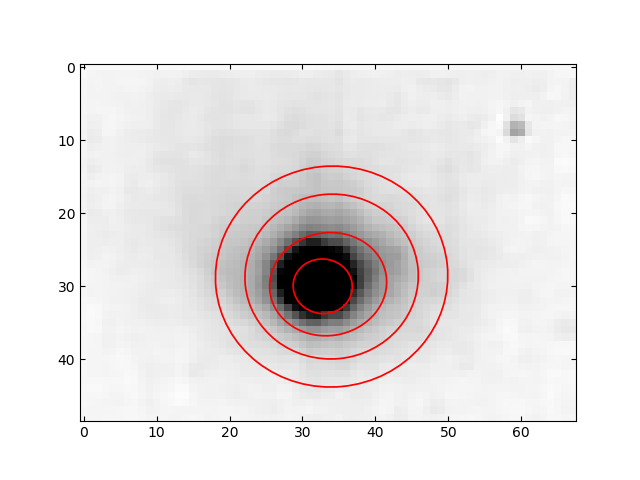

<IPython.core.display.Javascript object>


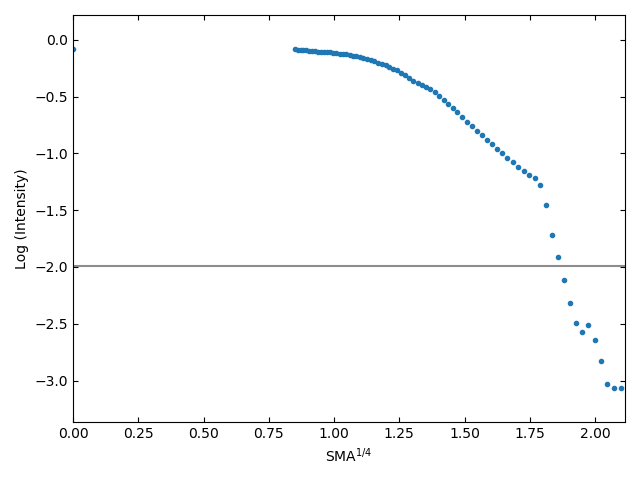

In [20]:
# iso_hst = fit_ellipse('hst_seg_msk.fits', 'hst_ell0.reg', step=0.05, maxsma=100.,
#                       plot_isophot=True, imgdata=hst_img, n_isophot=4,
#                       origin='lower', cmap='gray_r', vmin=-0.01, vmax=0.05,
#                       plot_profile=True, boundary_value=hst_boundary)
iso_gem = fit_ellipse('gem_seg_msk.fits', 'gem_ell0.reg', step=0.05, maxsma=20.,
                      plot_isophot=True, imgdata=gem_img, n_isophot=4,
                      origin='upper', cmap='gray_r', vmin=-0.01, vmax=0.2,
                      plot_profile=True, boundary_value=gem_boundary)

In [21]:
def get_boundary(iso_tbl, imgdata, boundary_value, regname,
                 origin='lower', cmap='gray_r', vmin=-0.01, vmax=0.05):
    '''
    iso_tbl - isophotal data table (dtype: astropy table)
    imgdata - the original image data array (dtype: np.array)
    boundary_value - the galaxy & tail boundary value (dtype: numpy.float)
    regname - the output region file name (dtype: string)
    '''
    
    # Plotting
    fig, ax = plt.subplots()
    ax.imshow(imgdata, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)

    idx = np.abs(iso_tbl['INTENS']-boundary_value).argmin()
    e = ell((iso_tbl['X0'][idx], iso_tbl['Y0'][idx]),
            width=2*iso_tbl['SMA'][idx],
            height=2*iso_tbl['SMA'][idx]*(1-iso_tbl['ELLIP'][idx]),
            angle=iso_tbl['PA'][idx]+90.,
            fill=False, color='blue', linestyle='-', linewidth=1.5)
    ax.add_patch(e)
    print(" ----- Boundary of 1 sigma (index:{0:d}) -----".format(idx))
    print("Center : ({0:.3f},{1:.3f})".format(iso_tbl['X0'][idx],iso_tbl['Y0'][idx]))
    print("Semi-major axis : {0:.3f}".format(iso_tbl['SMA'][idx]))
    print("Semi-minor axis : {0:.3f}".format(iso_tbl['SMA'][idx]*(1-iso_tbl['ELLIP'][idx])))
    print("Position angle : {0:.3f}".format(iso_tbl['PA'][idx]))

    plt.tight_layout()
    
    # Writing the result region file
    xc, yc = iso_tbl['X0'][idx], iso_tbl['Y0'][idx]
    a, b = iso_tbl['SMA'][idx], iso_tbl['SMA'][idx]*(1-iso_tbl['ELLIP'][idx])
    pa = iso_tbl['PA'][idx]+90.
    
    f = open(regname, "w")
    f.write("ellipse({0:.3f},{1:.3f},{2:.3f},{3:.3f},{4:.3f})".format(xc,yc,a,b,pa))
    f.close()

In [22]:
# get_boundary(iso_hst, hst_img, hst_boundary, 'HST_boundary_1sig.reg')

<IPython.core.display.Javascript object>


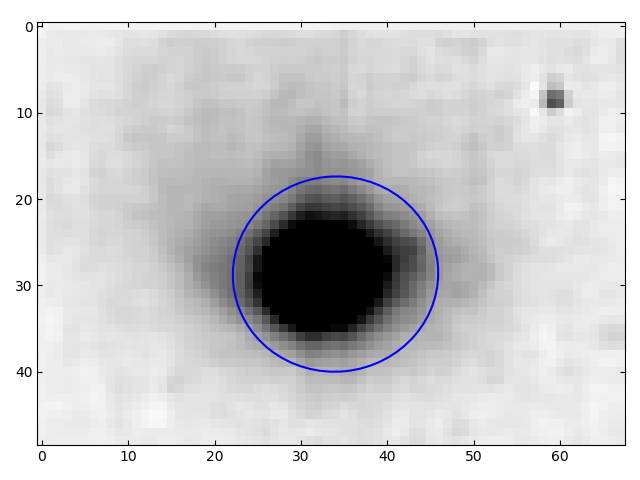

 ----- Boundary of 1 sigma (index:65) -----
Center : (33.996,28.683)
Semi-major axis : 11.890
Semi-minor axis : 11.295
Position angle : 84.364


In [23]:
get_boundary(iso_gem, gem_img, gem_boundary, 'GMOS_boundary_1sig.reg',
             origin='upper', cmap='gray_r', vmin=-0.01, vmax=0.1)